In [ ]:
<b> Title

In [1]:
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt

The QAOA Algorithm can be used to slove a varaity of optamization problems, one of such is the Max Cut problem. In a max cut problem we want to devide the nodes of a graph in to subsets such that the number of edges between the two sets is a large as possible. Below you can see a graph with four nodes in three different cuts. The third one shows the optimal partition of the sets. While this solution may be found easily for simple graphs, the amout of cuts scales exponentially with the number of edges.

In [ ]:
from IPython.display import Image
#Image('./image.png')

<b> How do we the optimization problem?
    
    The cost function which we try to minimize is given by:
    
    $ C(x) = \sum_{i,j} w_{i,j}x_i\left(1-x_j\right) \quad x_{i,j} \in \{0,1\} $
    
    ,where $ w_{i,j} $ accounts for the possibility of different weights for the edges (See Homework).
    
    Now we need to translate the cost function into an Hamiltonian for which the groundstate encods the optimal solution. For that we can use the Pauli Z operator on the computainonal basis $ x_i \to \frac{1-Z_i}{2} $.
<b> How does the corresponding Hamiltonian look like?

Lets find the soulution the the simple graph above using QAOA. We will build the quantum circuit step by step:
For a Graph with $n$ nodes we need a quantum register with $n$ qubits.

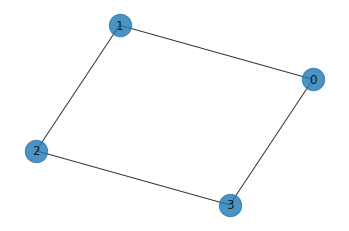

In [5]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2),(2, 3), (3, 0)])
pos=nx.spring_layout(G)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, pos = pos)

In [3]:
qaoa_circuit = QuantumCircuit(len(G.nodes()))

We start by preparing the initial state in a totaly mixed superpositon. This state is an eigenstate to the Mixer hamiltonian.

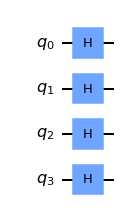

In [4]:
def initial_state(circuit):
    for i in range(circuit.num_qubits):
        circuit.h(i)
    return circuit

qaoa_circuit = initial_state(qaoa_circuit)
qaoa_circuit.draw()

The first step that has to be taken in order to act with our $H_c$ on our circuit is to express it as a unitary gate. Lets see how the ZZ Operator acts on a two qubit state. $e^{i\gamma Z\otimes Z}|ab\rangle = e^{-i (-1)^{a\bigoplus b} \gamma} |ab\rangle$. Consider the follwing gate:

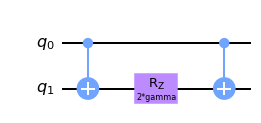

In [9]:
qc = QuantumCircuit (2)
gamma = Parameter ('gamma')
qc.rzz(2*gamma, 0, 1)
qc.decompose().draw()

And we can verify that this sequence of gates does indeed produce the desired state:

$|a\rangle|a\bigoplus b\rangle$ 
$|a\rangle|e^{-i (-1)^{a\bigoplus b} \gamma} a\bigoplus b\rangle$
$|a\rangle|e^{-i (-1)^{a\bigoplus b} \gamma} a\bigoplus b\rangle \bigoplus a  = e^{-i (-1)^{a\bigoplus b} \gamma} |ab\rangle $.

Now we need to implement this Z rotation for every edge in our graph:

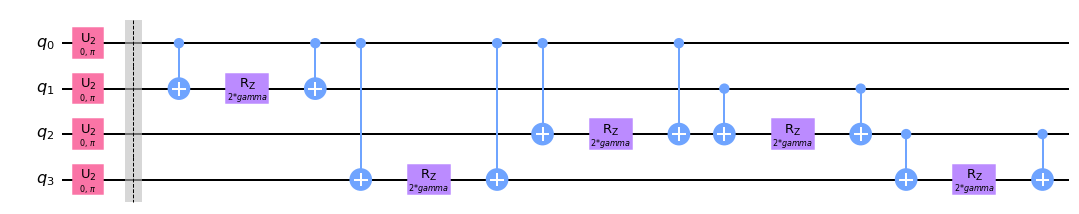

In [5]:
def problem_unitary(graph,circuit,gamma):
    for edge in list(G.edges()):
        circuit.rzz(2*gamma,edge[0],edge[1])
    return circuit
qaoa_circuit.barrier()
qaoa_circuit = problem_unitary(G, qaoa_circuit, gamma)
qaoa_circuit.decompose().draw()

The next step of the QAOA algorithm is the unitary matrix given by the Mixer Hamiltonian. It is simply a rotation around the X-axis by the angle $2\beta$ for all qubits.

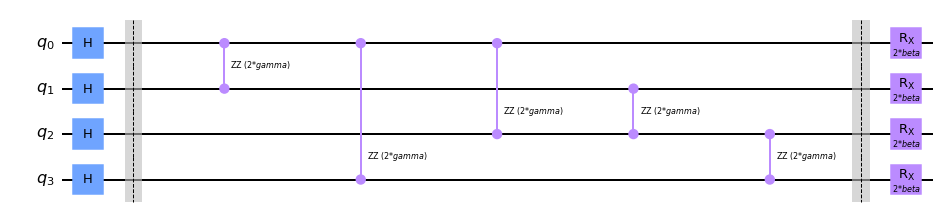

In [6]:
beta = Parameter('beta')
def mix_unitary(circuit,beta):
    for i in range(circuit.num_qubits):
        circuit.rx(2*beta,i)
    return circuit
qaoa_circuit.barrier()
qaoa_circuit = mix_unitary(qaoa_circuit, beta)
qaoa_circuit.draw()

We have now created one cycle of the trotterization in the QAOA algorithm (p=1). Next we generalize this to a circuit of p iteration of the Problem and Mixing Unitary. At the end of the circuit we measure all qubits in the computational basis.

In [7]:
def create_qaoa_circuit(graph, theta):
    p = len(theta)//2
    gamma = theta[p:]
    beta = theta[:p]
    qaoa_p = QuantumCircuit(len(graph.nodes()))
    qaoa_p = initial_state(qaoa_p)
    for i in range(p):
        qaoa_p = problem_unitary(graph, qaoa_p, gamma[i])
        qaoa_p = mix_unitary(qaoa_p, beta[i])
    qaoa_p.measure_all()
    return qaoa_p
    
    

Using the results from the quantum circuit we calculate the cost function. Let's code the cost function of our graph.

In [17]:
def get_cost(graph, state):
    cost = 0
    for i,j in graph.edges():
        if state[i] != state[j]:
            cost -= 1
    
    return cost

We take multiple shots of the quantum circuit and calcuate the expectation value of the cost function with this set of parameters. Then we can use a classical optimizer to minimize the expecation value and find the optimal state that sloves the Max Cut problem.

In [18]:
def expectation_value(graph, counts):
    avg = 0
    sum_count = 0
    for state, count in counts.items():
        cost = get_cost(graph, state)
        avg += cost*count
        sum_count += count
        
    return avg/sum_count

Let's put all togteher to create a function which we can classically optimize.

In [20]:
def run_qpu(graph, shots=512):
    backend = Aer.get_backend('aer_simulator')
    backend.shots = shots
    
    def run_circuit(theta):
        qc = create_qaoa_circuit(graph, theta)
        counts = backend.run(qc, seed_simulator = 5, nshots= shots).result().get_counts()
        return expectation_value(graph,counts)
    
    return run_circuit

In [21]:
from scipy.optimize import minimize

p=1
theta = [1.0 for i in range(2*p)]
exp_value = run_qpu(G)

res = minimize(exp_value, theta , method = 'COBYLA')
res

     fun: -3.1513671875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([2.172654  , 1.02112983])

<b> Analyzing the Results:
    
    We can now take our optimized parameters and run the circuit again:

In [ ]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circuit(G, res.x)

counts = backend.run(qc_res, seed_simulator = 5).result().get_counts()

plot_histogram(counts)

<b> Is this result what you expected? Why?